<a href="https://colab.research.google.com/github/andrewlod/deep-learning-notebooks/blob/main/BRLCoinSegmentationClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração e Downloads

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-22iklzfn
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-22iklzfn
  Created wheel for tensorflow-examples: filename=tensorflow_examples-e2371abfccceb278057ac692f8c532f527548bcc_-py3-none-any.whl size=271413 sha256=d7af475b70c666001f5c681823530085d084fcc0649051c8e1ecf45234e95b2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0zeyqcsg/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
#Dataset Download
!wget https://www.inf.ufpr.br/aghochuli/dataset3.zip -O dataset.zip
!unzip dataset.zip

--2021-10-18 21:26:37--  https://www.inf.ufpr.br/aghochuli/dataset3.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35758483 (34M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  34.10M  15.1MB/s    in 2.3s    

2021-10-18 21:26:40 (15.1 MB/s) - ‘dataset.zip’ saved [35758483/35758483]

Archive:  dataset.zip
   creating: dataset3/
  inflating: dataset3/5_1477189488.jpg  
  inflating: dataset3/100_1477280538.jpg  
  inflating: dataset3/50_1477282872.jpg  
  inflating: dataset3/10_1477147452.jpg  
  inflating: dataset3/50_1477283088.jpg  
  inflating: dataset3/10_1477288506.jpg  
  inflating: dataset3/10_1477288476.jpg  
  inflating: dataset3/100_1477281726.jpg  
  inflating: dataset3/5_1477290534.jpg  
  inflating: dataset3/5_1477292040.jpg  
  inflating: d

# Imports

In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from skimage.measure import label, regionprops
from skimage.transform import  resize
from skimage.color import rgb2gray,rgb2hsv
from skimage.filters import threshold_otsu, threshold_local
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow_examples.models.pix2pix import pix2pix
from skimage.filters import edges, median
from skimage.draw import ellipse

# Carregando imagens

In [ ]:
#Carregando para uma lista de imagens
imgs = []
for img_path in os.listdir('./dataset3/'):  
       
     imgs.append([io.imread('./dataset3/' + img_path),img_path])

print(len(imgs),"images loaded")

1000 images loaded


# Etapa 1: Segmentação

## Gerando máscaras

In [ ]:
block_size = 20

def mask_image(image):
  image = resize(image, (120,160), anti_aliasing=True)  #Resize para 160x120

  hsv_image = rgb2hsv(image)                            #Como visto nas plotagens acima, o HSV dá um destaque maior para as imagens
  saturation = hsv_image[:,:,1]                         #Canal S (HSV)
  filtered = median(saturation, np.ones((3,3)))         #Filtro (mediana)

  sat_thresh = threshold_otsu(filtered, block_size)     #Threshold automático
  sat_binary = filtered > sat_thresh

  labeled = label(sat_binary)                           #Identifica regiões conectadas
  regions = regionprops(labeled)                        #Extrai propriedades das regiões conectadas

  for region in regions:
    if region["Area"] < 20:                             #Ignora regiões muito pequenas
      continue
    
    minr, minc, maxr, maxc = region["BoundingBox"]      #r = row, c = column, coordenadas do retângulo da região

    ratio = (maxc - minc) / (maxr - minr)               

    if not (0.9 < ratio < 1.1):                         #Quero quadrados
      continue
    
    y0, x0 = region.centroid
    rr, cc = ellipse(y0, x0, (maxc - minc)//2+1, (maxc - minc)//2+1, (120,160))
    
    black_image = np.zeros((120,160,1), np.float32)
    black_image[rr,cc] = [1]

    return black_image, image

    cropped = image[minr:maxr,minc:maxc]                #Moeda recortada
    return cropped, image, (minr, minc, maxr, maxc)     #Imagem recortada, original, coordenadas do retângulo
    
  return None                                           #Falhou


In [ ]:
images = []
masks = []
labels = []

for img in imgs:
  detected_image = img[0].copy()
  result = mask_image(detected_image)
  if result is None:  #Verifica se ela foi encontrada ou não
    continue
  
  result, image = result
  images.append(image)
  masks.append(result)
  labels.append(img[1])
  
len(images)

889

## Preparando o dataset

In [ ]:
#Redimensionar imagens
def resize_image(datapoint):
  input_image = tf.image.resize(datapoint['images'], (128, 128))
  input_mask = tf.image.resize(datapoint['masks'], (128, 128))

  return input_image, input_mask

In [ ]:
#Parâmetros de treino e teste
TRAIN_LENGTH = int(len(images)*0.7)
TEST_LENGTH = len(images) - TRAIN_LENGTH
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
dataset = list(zip(images, masks))

In [ ]:
#Separação treino/teste
_train_images, _test_images, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.3)

In [ ]:
train_images = [im[0] for im in _train_images]
train_masks = [im[1] for im in _train_images]
features_dict_train = {'images': train_images, 'masks': train_masks}
test_images = [im[0] for im in _test_images]
test_masks = [im[1] for im in _test_images]
features_dict_test = {'images': test_images, 'masks': test_masks}

In [ ]:
#Conversão para tf.data.Dataset
train_images = tf.data.Dataset.from_tensor_slices(features_dict_train).map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = tf.data.Dataset.from_tensor_slices(features_dict_test).map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
#Augmentation (horizontal flip)
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
#Geração de augmentation
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

## Visualizando o dataset

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

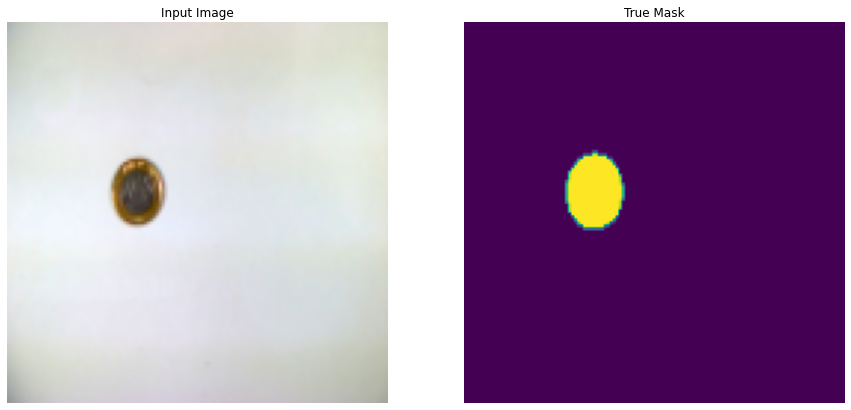

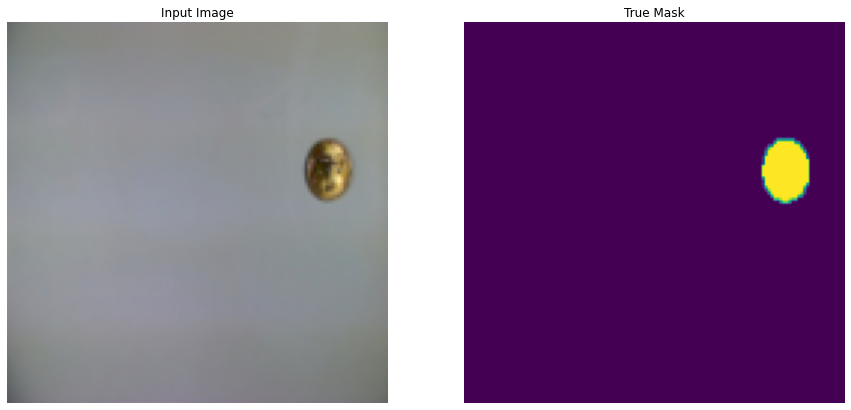

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Configuração da UNet

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

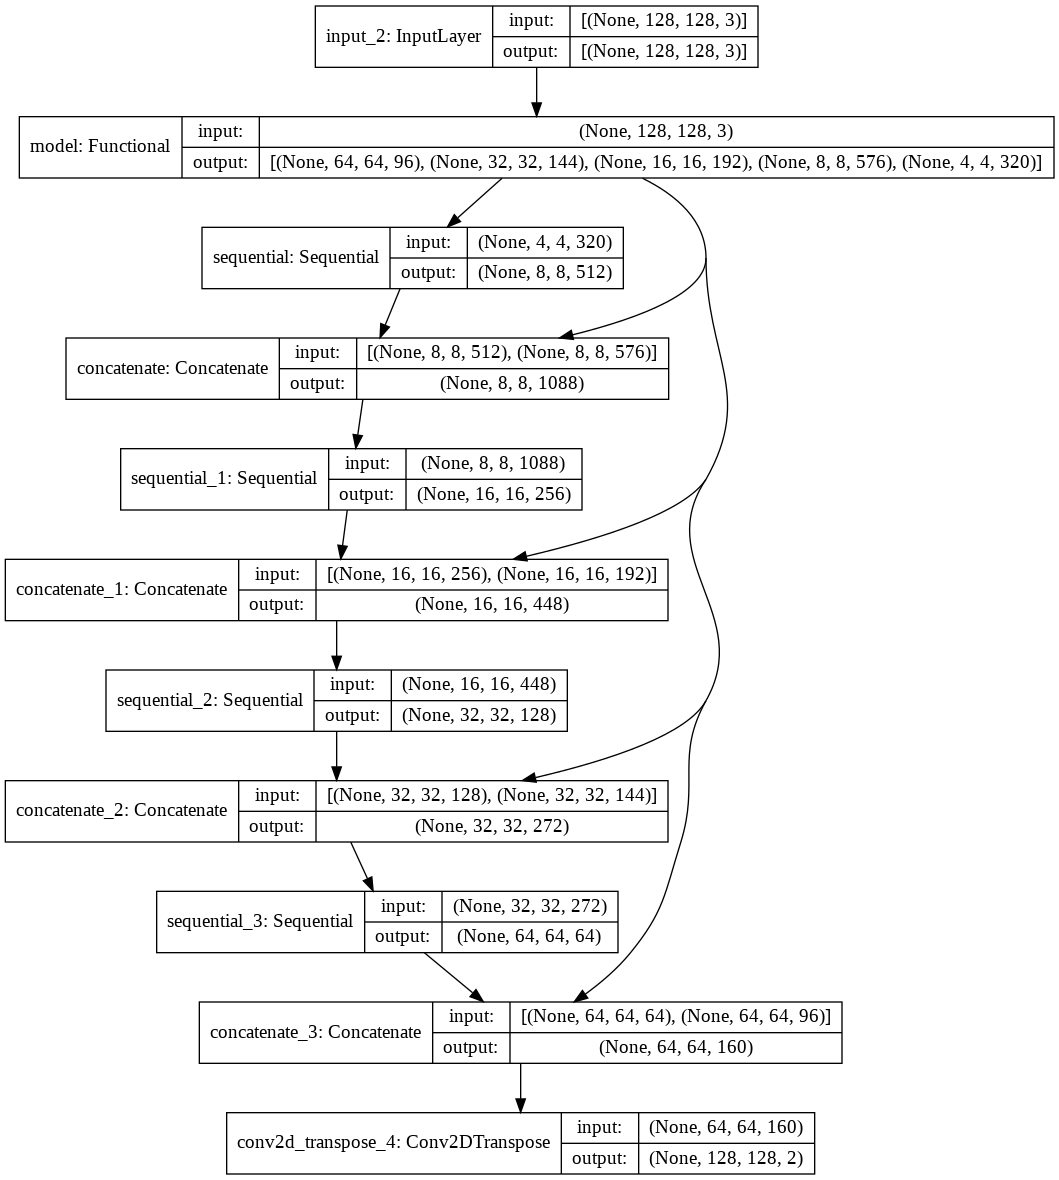

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask, idx=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[idx]

In [ ]:
def show_predictions(dataset=None, num=1, num2=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      for i in range(num2):
        display([image[i], mask[i], create_mask(pred_mask, i)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

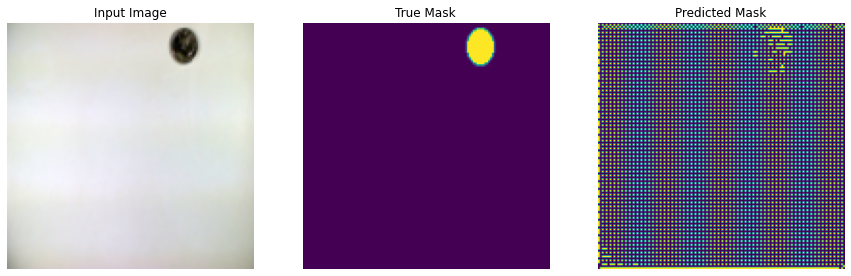

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Treinamento da UNet

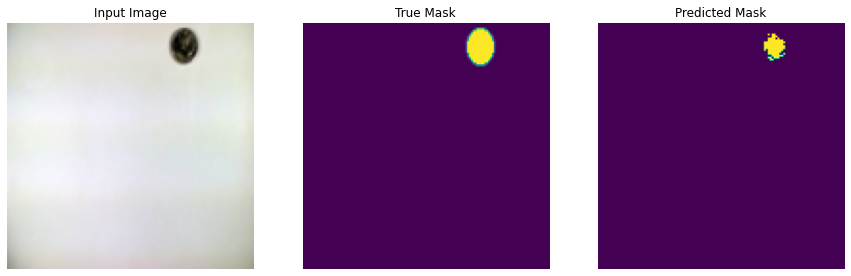


Sample Prediction after epoch 8



In [ ]:
EPOCHS = 8
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

## Visualização dos resultados

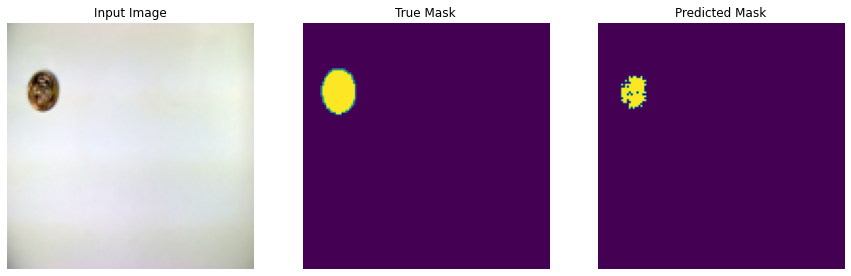

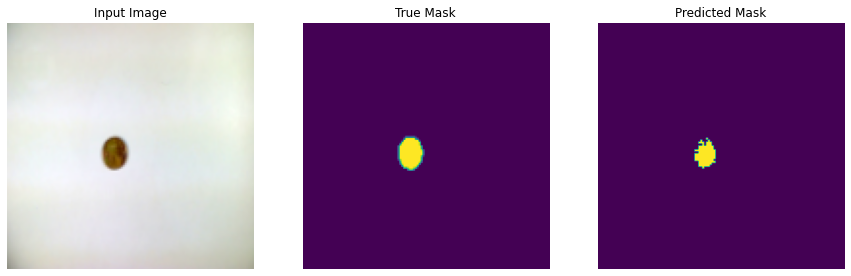

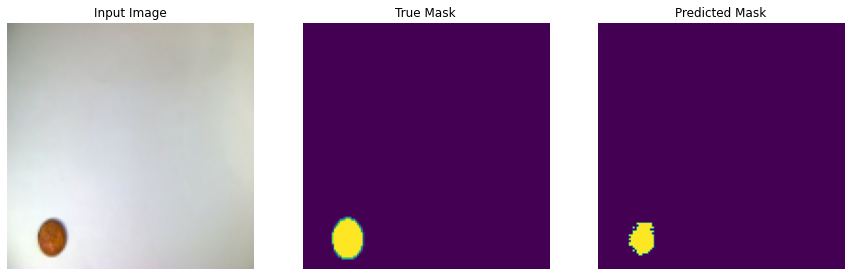

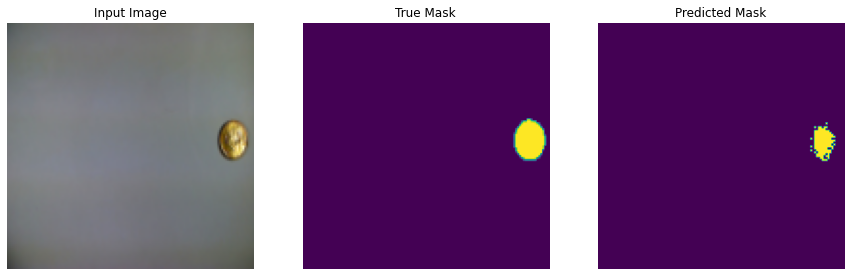

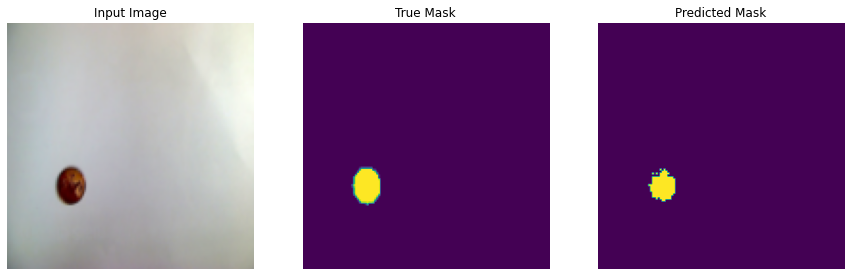

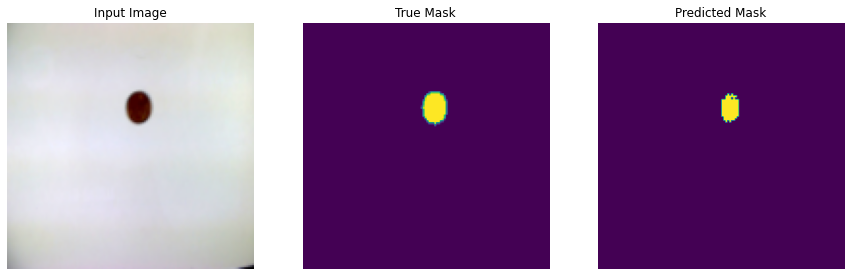

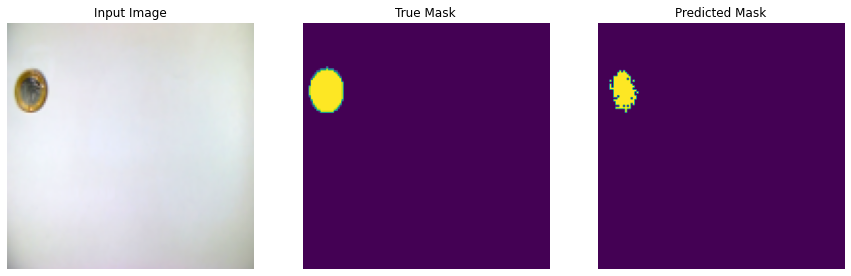

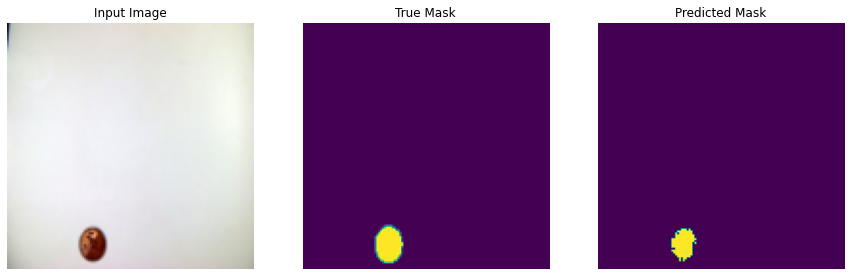

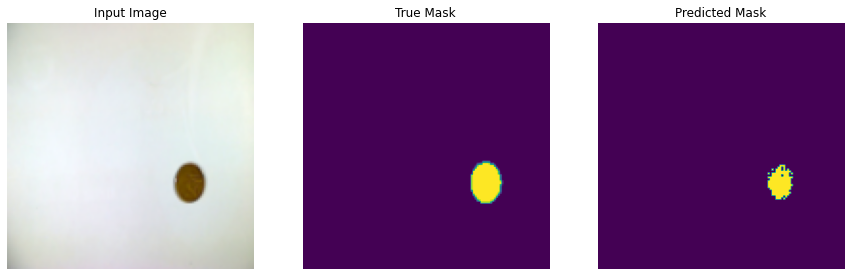

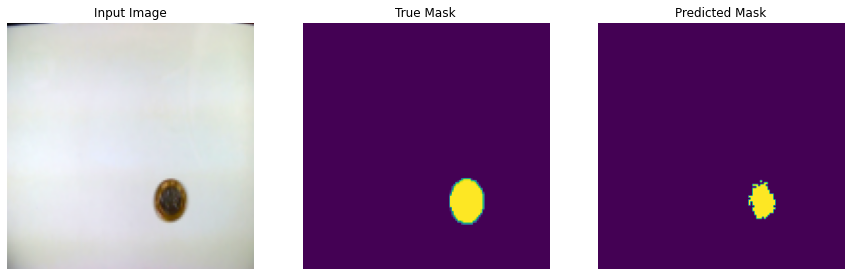

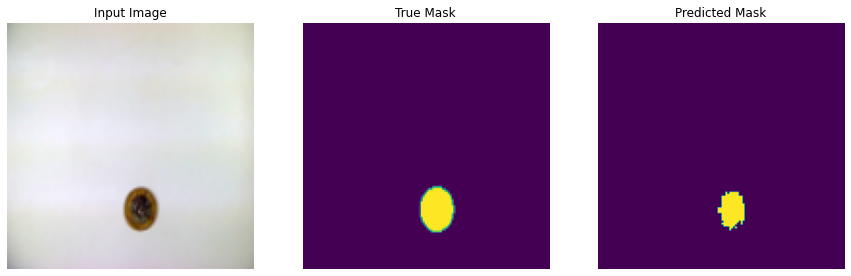

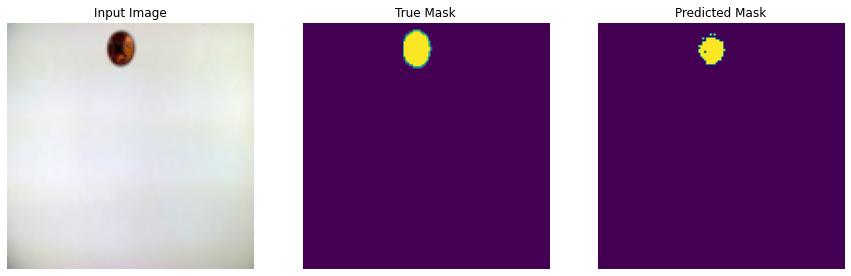

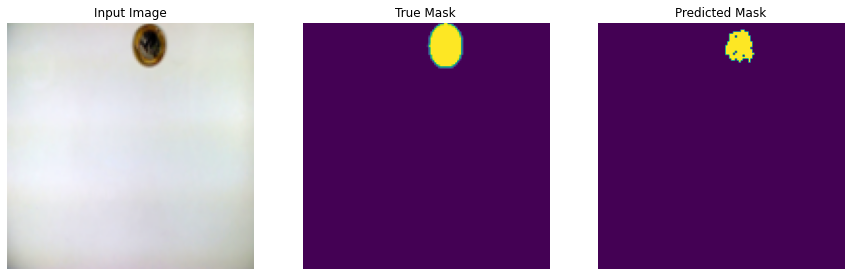

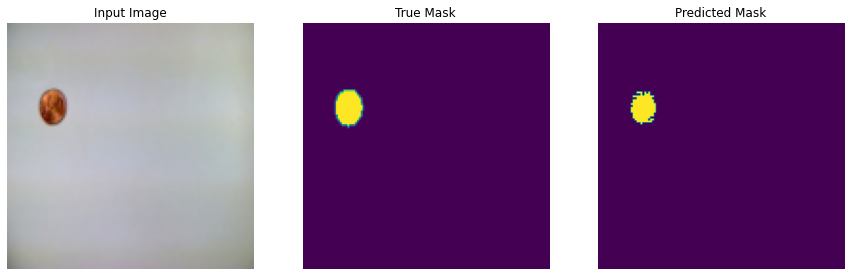

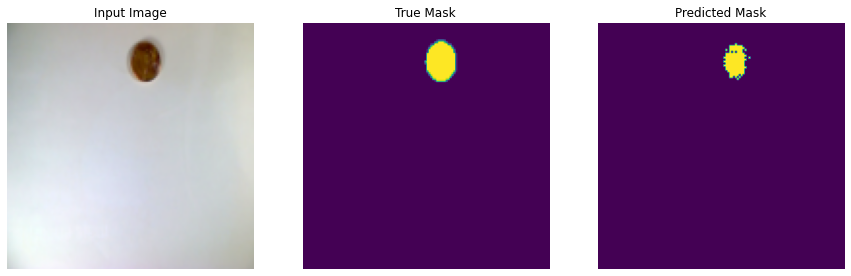

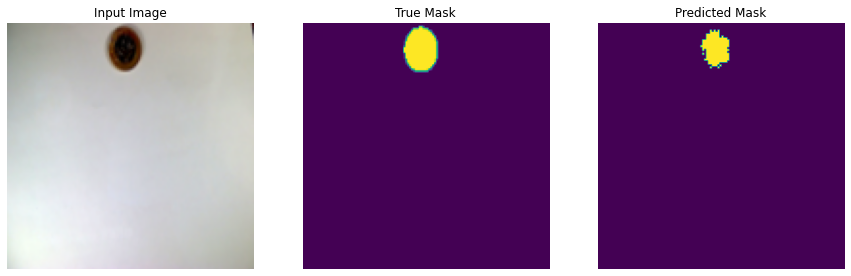

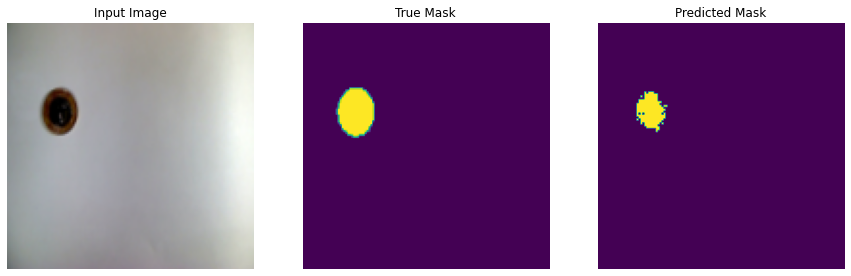

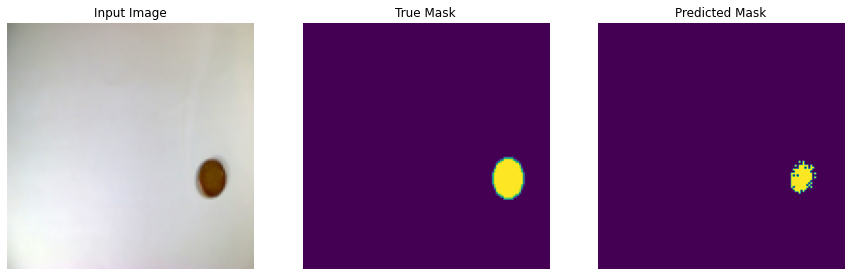

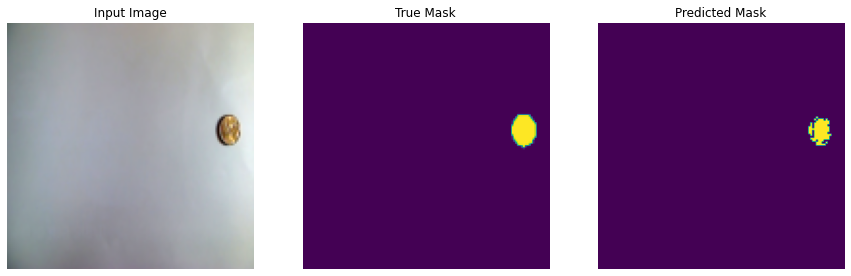

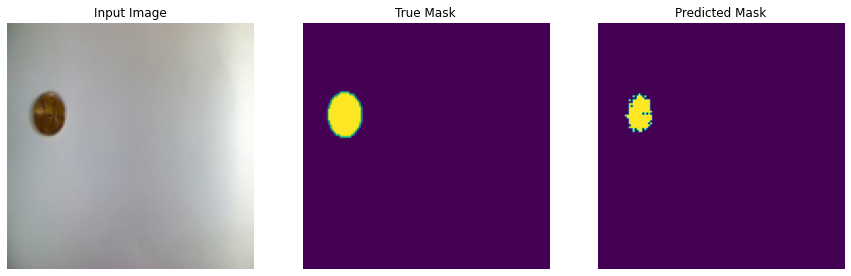

In [ ]:
show_predictions(test_batches, 5, 4)

## Extraindo a moeda

In [ ]:
def get_coin_bounds(mask):
  _xmin, _xmax, _ymin, _ymax = -1,-1,-1,-1
  y, x = mask.shape[:2]

  for i in range(y):
    for j in range(x):
      if mask[i,j][0] == 1:
        if _ymin == -1:
          _ymin = i
        if _xmin == -1 or j < _xmin:
          _xmin = j
        if i > _ymax:
          _ymax = i
        if j > _xmax:
          _xmax = j
    
  return (_xmin, _ymin, _xmax, _ymax)

In [ ]:
def create_mask_one(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

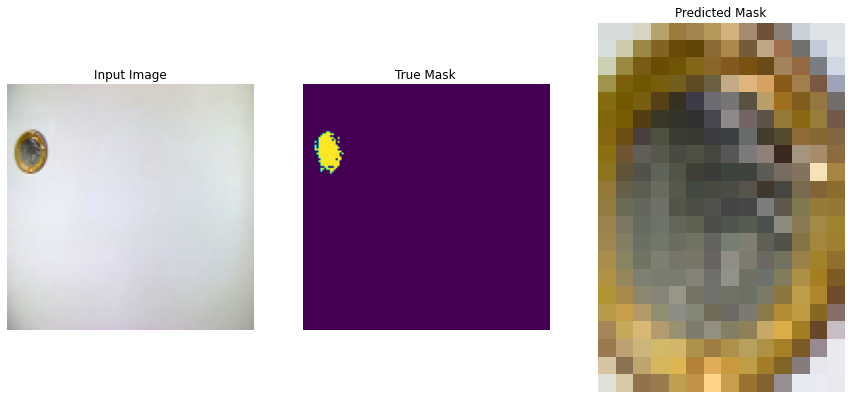

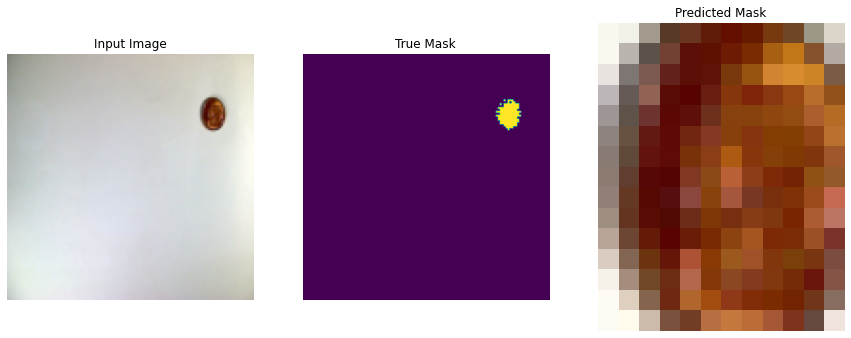

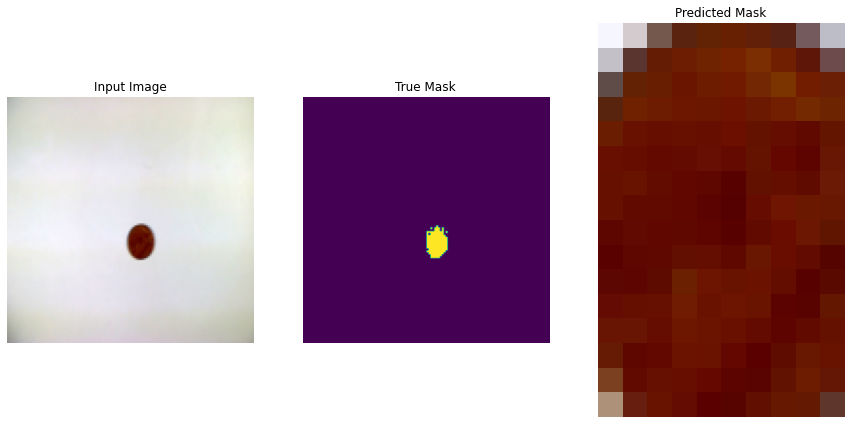

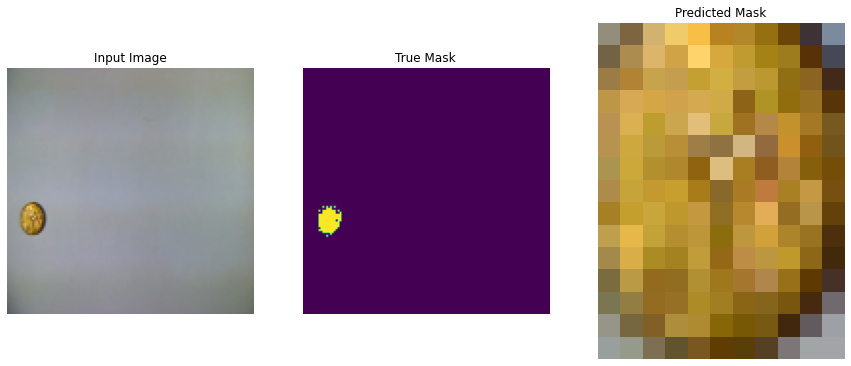

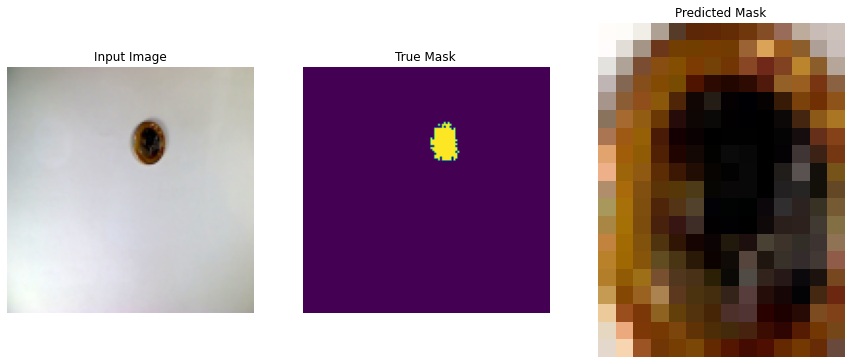

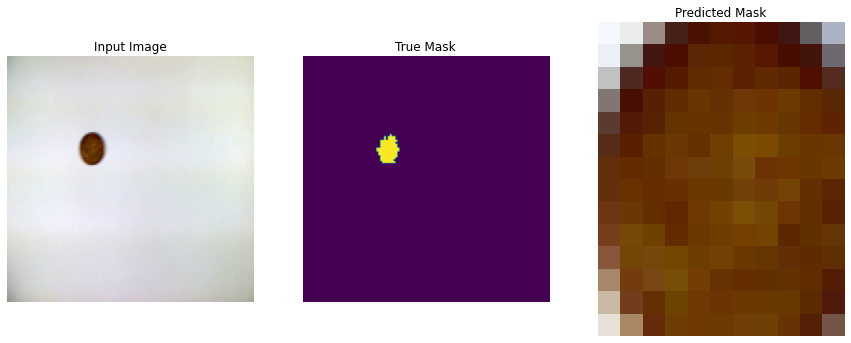

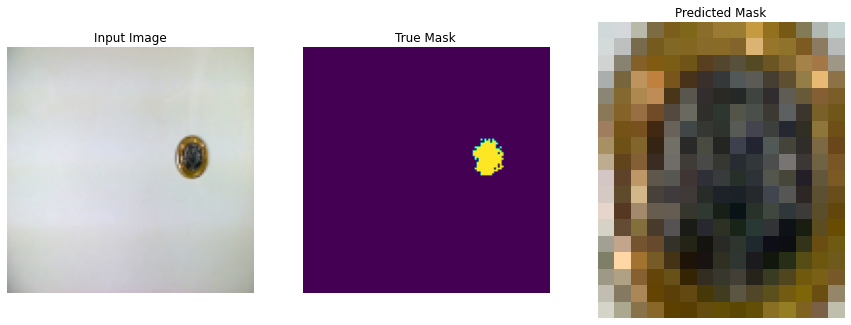

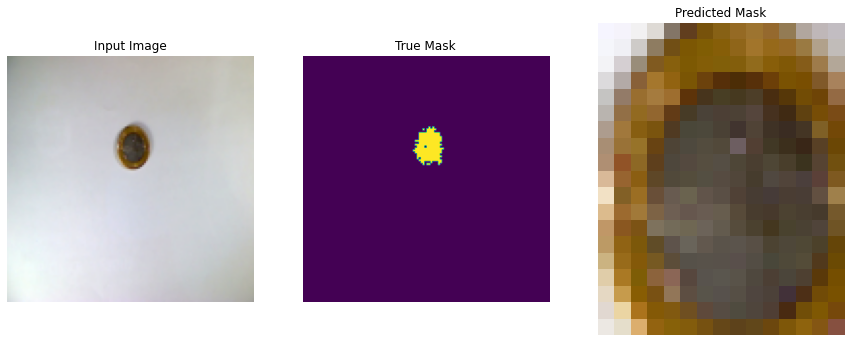

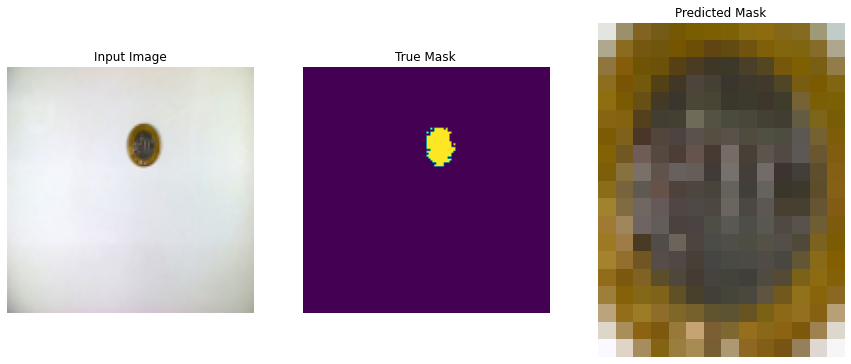

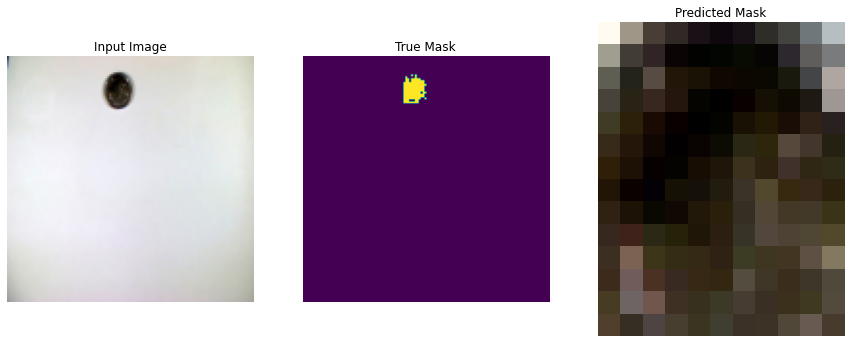

In [ ]:
for i in range(10):
  a = resize(imgs[i][0], (128,128), anti_aliasing=True)
  pred_mask = model.predict(np.array([a]))
  _xmin, _ymin, _xmax, _ymax = get_coin_bounds(create_mask_one(pred_mask[0]))
  display([a,create_mask_one(pred_mask[0]), a[_ymin:_ymax, _xmin:_xmax]])

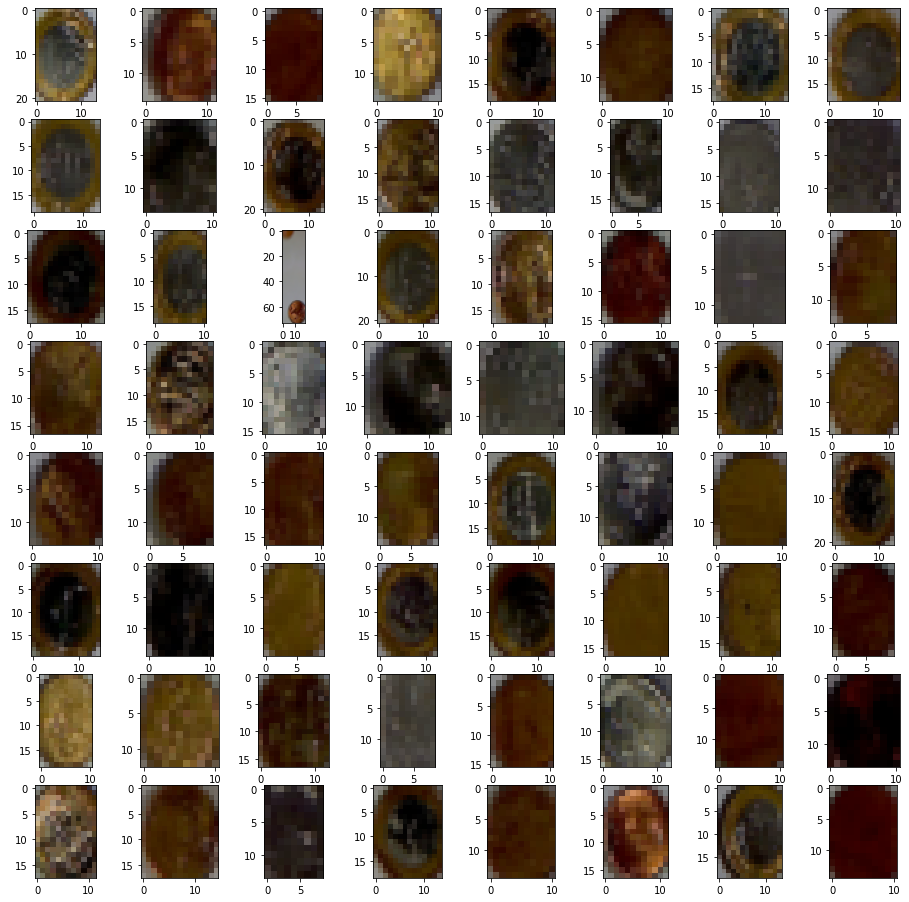

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
ax = axes.ravel()

resized_imgs = []
y = []

for img in imgs:
  resized_imgs.append(resize(img[0], (128,128), anti_aliasing=True))
  y.append(img[1])

seg_imgs = model.predict(np.array(resized_imgs))
i = 0
for img, seg_img in zip(resized_imgs, seg_imgs):
  _xmin, _ymin, _xmax, _ymax = get_coin_bounds(create_mask_one(seg_img))
  ax[i].imshow(img[_ymin:_ymax, _xmin:_xmax])
  i+=1
  if i >= 64:
    break

plt.show()

## Conclusão: Etapa de Segmentação

Das 64 moedas mostradas acima, apenas uma teve resultados inconsistentes, onde aparentemente há um outro objeto na imagem, fazendo com que o classificador identifique aquela outra região como parte de uma moeda. Caso a taxa de erro de 1 em 64 moedas se mantenha pelo dataset inteiro, isso implica em cerca de 984 imagens cortadas corretamente, contra 889 da segmentação manual efetuada anteriormente, representando uma significativa vantagem perante à aproximação anterior.

# Etapa 2: Classificação com CNN

## Criando e preparando o dataset

In [ ]:
#Extração de cada moeda baseado em sua máscara
X = []

for img, seg_img in zip(resized_imgs, seg_imgs):
  _xmin, _ymin, _xmax, _ymax = get_coin_bounds(create_mask_one(seg_img))
  X.append(resize(img[_ymin:_ymax, _xmin:_xmax], (64,64), anti_aliasing=True))

In [ ]:
#Convertendo nomes de classes em números para classificação
convert_classes = {'5': 0, '10': 1, '25': 2, '50': 3, '100': 4}
y = [convert_classes[instance[1].split("_")[0]] for instance in imgs]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)    #Separa em treino e teste

In [ ]:
X_train_model, X_val, y_train_model, y_val = train_test_split(X_train, y_train, test_size=0.3)    #Separa em treino e validação

## Classificação com augmentation

Após realização de vários treinos, foi encontrado que 44 epochs é o melhor valor para treinamento. Mais epochs poderá resultar em overfitting.

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20)
train_aug = train_gen.flow(np.array(X_train), np.array(y_train), batch_size=5000, shuffle=True)
val_gen = ImageDataGenerator()
val_aug = val_gen.flow(np.array(X_train), np.array(y_train), batch_size=len(y_train)//2, shuffle=True)

X_val_aug, y_val_aug = next(val_aug)

X_train_aug, y_train_aug = next(train_aug)
for i in range(1):
  x,y = next(train_aug)
  X_train_aug = np.append(X_train_aug, x, axis=0)
  y_train_aug = np.append(y_train_aug, y, axis=0)

In [ ]:
batch_size = 1000
epochs = 44
height = 64
width = 64

model = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(height, width ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, 'softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

my_history = model.fit(x=np.array(X_train_aug), y=np.array(y_train_aug), validation_data = (np.array(X_val), np.array(y_val)), epochs=epochs)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 8, 128)       

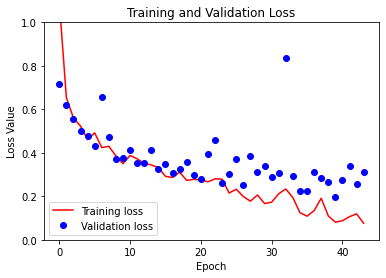

In [ ]:
loss = my_history.history['loss']
val_loss = my_history.history['val_loss']

plt.figure()
plt.plot(my_history.epoch, loss, 'r', label='Training loss')
plt.plot(my_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def top_class_idx(prediction):
  idx = 0
  best = 0
  for i, cl in enumerate(prediction):
    if cl > best:
      best = cl
      idx = i
  
  return idx

predictions = model.predict(np.array(X_test))

In [ ]:
predictions_classes = [top_class_idx(a) for a in predictions]

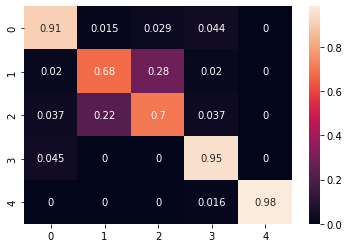

In [ ]:
cm = confusion_matrix(y_test, predictions_classes, normalize='true')
sns.heatmap(cm, annot=True)

In [ ]:
accuracy_score(y_test, predictions_classes)

0.86

## Classificação sem augmentation

Como o conjunto de dados é menor sem augmentation, foi optado por utilizar mais epochs.

In [ ]:
batch_size = 1000
epochs = 75
height = 64
width = 64

model_no_aug = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(height, width ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, 'softmax')
])
model_no_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_no_aug.summary())

no_aug_history = model_no_aug.fit(x=np.array(X_train_model), y=np.array(y_train_model), validation_data = (np.array(X_val), np.array(y_val)), epochs=epochs)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 8, 8, 128)       

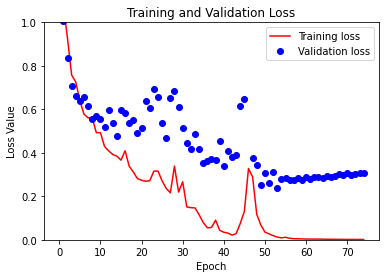

In [ ]:
loss = no_aug_history.history['loss']
val_loss = no_aug_history.history['val_loss']

plt.figure()
plt.plot(no_aug_history.epoch, loss, 'r', label='Training loss')
plt.plot(no_aug_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
predictions = model_no_aug.predict(np.array(X_test))

In [ ]:
predictions_classes = [top_class_idx(a) for a in predictions]

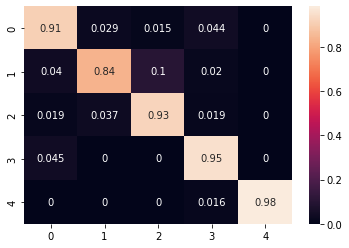

In [ ]:
cm = confusion_matrix(y_test, predictions_classes, normalize='true')
sns.heatmap(cm, annot=True)

In [ ]:
accuracy_score(y_test, predictions_classes)

0.9266666666666666

# Análise final

Quanto aos resultados gerais, a classificação sem augmentation obteve uma acurácia de 92,6%, contra 86% da classificação com augmentation. Um dos possíveis motivos para tal diferença é o tamanho do dataset, em que 1000 imagens não é considerado um alto número. Isso pode fazer com que a aproximação com augmentation aprenda exemplos que não estão contidos naquele dataset, e possivelmente "poluindo" o treinamento, ou dando a ele um viés diferente do dataset original. Já o treinamento sem augmentation aprende características específicas daquele conjunto de dados, dando melhores resultados mesmo se a generalização não for tão boa quanto com augmentation.

Quanto às comparações classe a classe, ambos os classificadores fazem um excelente trabalho ao classificar as moedas de 5, 50 e 100 (0, 3 e 4) e a maior diferença ocorre nas moedas de 10 e 25 (1 e 2), onde houve uma certa mistura no classificador com augmentation, enquanto no classificador sem augmentation, apesar de ainda ter uma acurácia inferior às outras classes na moeda de 10, ainda há uma mistura muito menor do que a outra aproximação.

Pode-se notar, além disso, que pelos valores de loss e acurácia no modelo sem augmentation, que a partir da epoch 60, não há um aumento significativo no aprendizado dos dados.

Comparado ao trabalho anterior, onde o modelo SVM + PCA obteve uma acurácia de 85%, houve um considerável salto no modelo de Segmentação + CNN sem augmentation, para um total de 92%. Classe a classe, pode-se ver que o modelo anterior obteve taxas de acerto extremamente altas nas moedas de 50 e 100, com valores de 97% e 100%, respectivamente, porém, o mesmo não se aplica às outras moedas, que estiveram na faixa dos 76-82%, enquanto o modelo atual é consistente em todas as moedas, com a pior classe sendo a de 10 centavos, e as outras variando entre 91 e 98%.